# Running Model

Calibrated params from calibration_us_gdp.ipynb

In [1]:
# Import packages
from abm_funs import *
from plot_funs import*
# from us_input import *
import numpy as np
from copy import deepcopy 
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import math as math
from copy import deepcopy
import os
import seaborn as sns
import datetime
from collate_macro_vars import *
from statsmodels.tsa.filters import hp_filter, bk_filter, cf_filter
from quantecon import hamilton_filter
from statsmodels.tsa.seasonal import seasonal_decompose
import csv

rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/"

import os
print(os.cpu_count()) 

save = False

NEW Function import successful
8


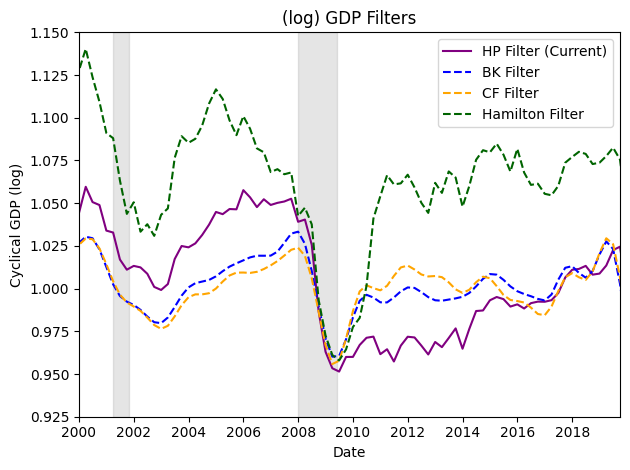

In [2]:
#realgdp = macro_observations[["DATE", "REALGDP"]].dropna(subset=["REALGDP"]).reset_index()
realgdp['log_REALGDP'] = np.log2(realgdp['REALGDP'])

# GDP Filter
cycle, trend = hp_filter.hpfilter(realgdp['log_REALGDP'], lamb=129600)
 
# Adding the trend and cycle to the original DataFrame
realgdp['log_Trend'] = trend+1
realgdp['log_Cycle'] = cycle+1
realgdp['Trend'] = np.exp(trend)
realgdp['Cycle'] = np.exp(cycle)

realgdp_no_covid = realgdp[realgdp['DATE'] < "2019-10-1"].copy()
realgdp['scaled_log_Cycle'] = (realgdp['log_Cycle'] - realgdp['log_Cycle'].min()) / (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min())
realgdp_no_covid['scaled_log_Cycle'] = (realgdp_no_covid['log_Cycle'] - realgdp_no_covid['log_Cycle'].min()) / (realgdp_no_covid['log_Cycle'].max() - realgdp_no_covid['log_Cycle'].min())


k = 12
bk_cycle = bk_filter.bkfilter(realgdp['log_REALGDP'], low=6, high=32, K=k) + 1
padded_series = pd.Series(
    [np.nan]*k + list(bk_cycle) + [np.nan]*k,
    index=realgdp.index  
)

# Add it to the DataFrame
realgdp['bk_gdp'] = padded_series

k = 12
cf_cycle = cf_filter.cffilter(realgdp['log_REALGDP'], low=6, high=32, drift = True)[0] + 1
# Add it to the DataFrame
realgdp['cf_gdp'] = cf_cycle

# 8 recommended for quarterly data: https://quanteconpy.readthedocs.io/en/latest/tools/filter.html
H = 8
hamilton_cycle = hamilton_filter(realgdp['log_REALGDP'], h = H)[0] + 1

# Add it to the DataFrame
realgdp['hamilton_gdp'] = hamilton_cycle

# Main axis
fig, ax1 = plt.subplots()

# Plot on main axis
line1, = ax1.plot(realgdp['DATE'], realgdp['log_Cycle'], label="HP Filter (Current)", color="purple")
line2, = ax1.plot(realgdp['DATE'], realgdp['bk_gdp'], label="BK Filter", color="blue", linestyle="dashed")
line3, = ax1.plot(realgdp['DATE'], realgdp['cf_gdp'], label="CF Filter", color="orange", linestyle="dashed")
line4, = ax1.plot(realgdp['DATE'], realgdp['hamilton_gdp'], label="Hamilton Filter", color="darkgreen", linestyle="dashed")
ax1.set_ylabel("Cyclical GDP (log)")
ax1.set_ylim([0.925, 1.15])

# # Twin axis
# ax2 = ax1.twinx()
# line3, = ax2.plot(macro_observations['DATE'], macro_observations['UER'], label="UER", color="red", linestyle="dotted")
# line4, = ax2.plot(macro_observations['DATE'], macro_observations['VACRATE'], label="VACRATE", color="blue", linestyle="dotted")
# ax2.set_ylabel("UER & VACRATE")
# ax2.set_ylim([0.01, 0.12])

# Set common attributes
ax1.set_xlim([datetime.date(2000, 1, 1), datetime.date(2019, 10, 1)])
ax1.set_title("(log) GDP Filters")
ax1.set_xlabel("Date")

ax1.fill_between(
    recessions['DATE'], 0, 1,
    where=recessions['USREC'] == 1,
    transform=ax1.get_xaxis_transform(),
    color='grey', alpha=0.2, label='Recession'
)
# Combine legends
lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

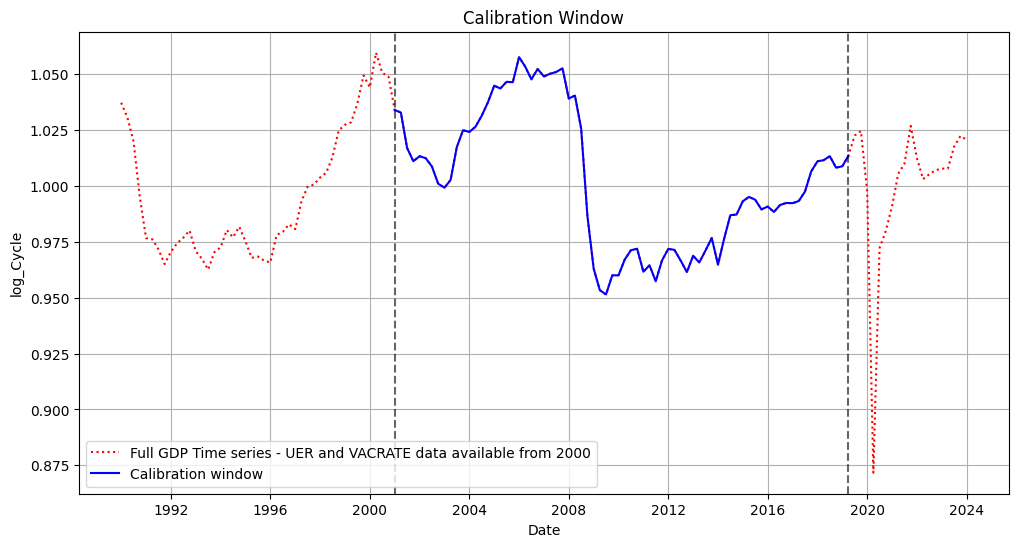

In [3]:
# Different calibration windows
# Full time series: "2024-5-1"
# calib_date = ["2004-12-01", "2019-05-01"]
calib_date = ["2000-12-01", "2019-05-01"]
# calib_date = ["2000-12-01", "2024-05-01"]
gdp_dat_pd = realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]
gdp_dat = np.array(gdp_dat_pd['log_Cycle'])
gdp_dat_bk = np.array(gdp_dat_pd['bk_gdp'])
gdp_dat_hamilton = np.array(gdp_dat_pd['hamilton_gdp'])

# PLOTTING
plt.figure(figsize=(12, 6))

# Plot original data
sns.lineplot(data = realgdp, x = 'DATE', y = 'log_Cycle', color = "red", label = "Full GDP Time series - UER and VACRATE data available from 2000", linestyle = "dotted")
sns.lineplot(data=gdp_dat_pd, x='DATE', y='log_Cycle', color='blue', label='Calibration window')

# Mark original data boundaries
plt.axvline(x=gdp_dat_pd['DATE'].min(), color='black', linestyle='--', alpha=0.6)
plt.axvline(x=gdp_dat_pd['DATE'].max(), color='black', linestyle='--', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('log_Cycle')
plt.title('Calibration Window')
plt.legend()
plt.grid(True)
plt.show()

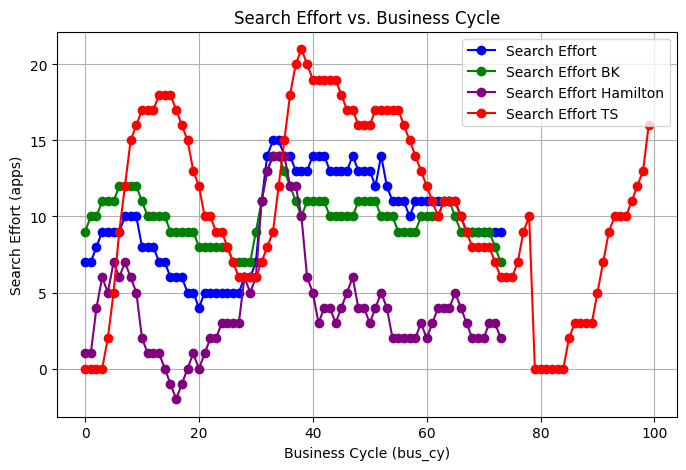

In [4]:
# Search Effort Time Series
search_effort_dat = pd.read_csv("data/quarterly_search_ts.csv")
search_effort_dat['DATE'] = pd.to_datetime(search_effort_dat['year'].astype(str) + '-' + (search_effort_dat['quarter'] * 3 - 2).astype(str) + '-01')
search_effort_np = np.array(search_effort_dat['value_smooth'])
search_effort_np = search_effort_np/search_effort_np.mean()
#realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]

# Define a range of bus_cy values  # Generates 100 values from 0 to 1
search_effort_values = [search_effort(0, b) for b in gdp_dat]  # Apply function
search_effort_bk_values = [search_effort(0, b) for b in gdp_dat_bk]  # Apply function
search_effort_hamilton_values = [search_effort(0, b) for b in gdp_dat_hamilton]  # Apply function
# def search_effort_ts(t_unemp, se):
#     apps = max(0, round(10 - 100*(1-se)))
#     # if discouraged:
#     #     apps = round(a_stable/((t_unemp)**2 + 1)) + 1
#     return apps
search_effort_values_dyn = [search_effort_ts(0, b) for b in search_effort_np]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='b', label="Search Effort")
plt.plot(range(len(search_effort_bk_values)), search_effort_bk_values, marker='o', linestyle='-', color='g', label="Search Effort BK")
plt.plot(range(len(search_effort_hamilton_values)), search_effort_hamilton_values, marker='o', linestyle='-', color='purple', label="Search Effort Hamilton")

plt.plot(range(len(search_effort_values_dyn)), search_effort_values_dyn, marker='o', linestyle='-', color='r', label="Search Effort TS")
plt.xlabel("Business Cycle (bus_cy)")
plt.ylabel("Search Effort (apps)")
plt.title("Search Effort vs. Business Cycle")
plt.legend()
plt.grid(True)
plt.show()

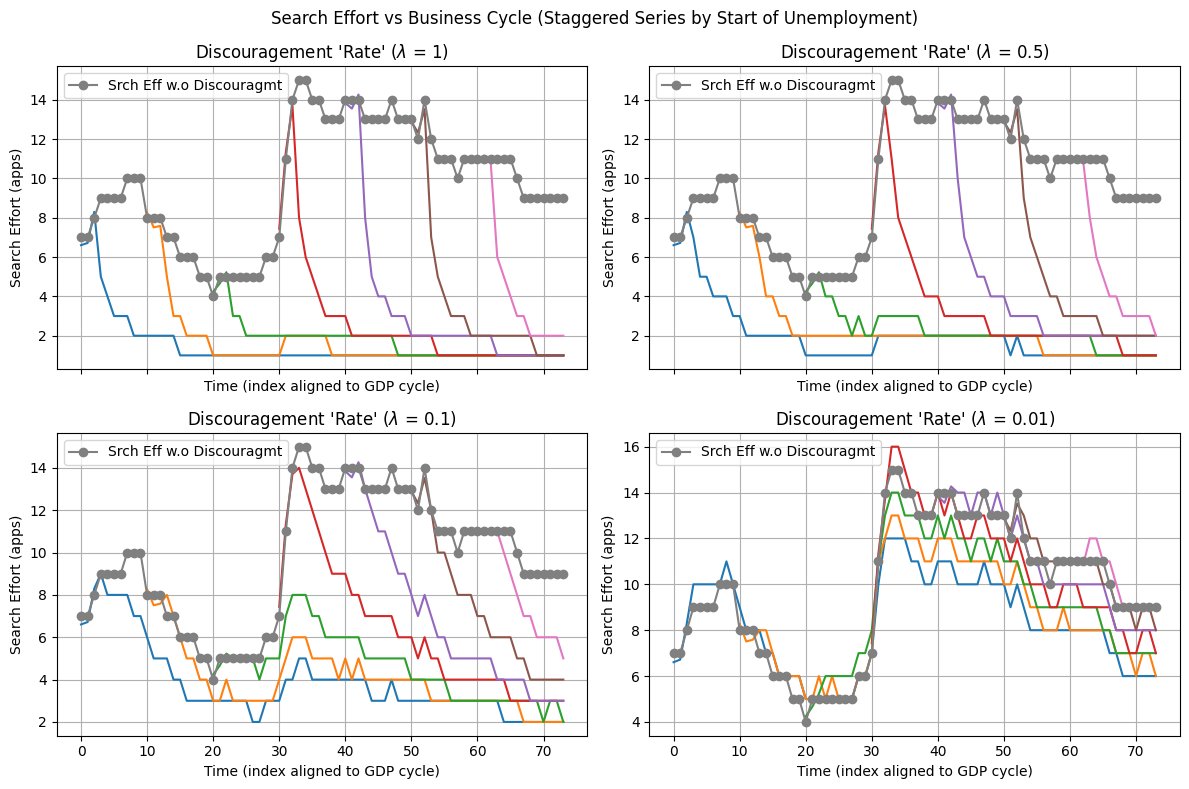

In [113]:
fig, axes = plt.subplots(2,2, figsize=(12, 8), sharex=True)
for i, a in enumerate([1, 0.5, 0.1, 0.01]):
    def search_effort_unemp(t_unemp, bus_cy):
        apps = 10 + 100 * (1 - bus_cy)
        if t_unemp > 2:
            apps = round(apps / ((a*(t_unemp-2)) + 1)) + 1
        return apps

    # Let's define some arbitrary starting points
    start_points = [0, 10, 20, 30, 40, 50, 60]  # You can choose any index offsets
    series_dict = {}

    for start in start_points:
        efforts = []
        for t_unemp, bus_cy in enumerate(gdp_dat[start:]):
            apps = search_effort_unemp(t_unemp, bus_cy)
            efforts.append(apps)
        series_dict[f"Start @ {start}"] = {
            "x": list(range(start, start + len(efforts))),
            "y": efforts
        }

    # Plot
    ax = axes[i//2, i%2]
    for label, data in series_dict.items():
        ax.plot(data["x"], data["y"], linestyle='-')

    ax.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='grey', label="Srch Eff w.o Discouragmt")
    ax.set_title(f"Discouragement 'Rate' ($\lambda$ = {a})")
for ax in axes.flat:
    ax.set_xlabel("Time (index aligned to GDP cycle)")
    ax.set_ylabel("Search Effort (apps)")

    ax.legend(loc='upper left')
    ax.grid(True)
plt.suptitle("Search Effort vs Business Cycle (Staggered Series by Start of Unemployment)")
plt.tight_layout()
plt.show()

### Unemployed Search Effort Time Series

In [5]:
# Macro observations
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset=["UNRATE", "VACRATE"]).reset_index()
# Load US_input data
A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

###################################
# Initialise the model
##################################
net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 3)

# observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
# Load calibrated parameters from CSV
param_df = pd.read_csv("output_18_04/dist_50_50/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_df = param_df.sort_values(by='Timestamp', ascending=False)

# Keep only the latest version of each parameter by removing duplicates
param_df = param_df.drop_duplicates(subset=['Parameter', 'Behav_Mode'], keep='first')
print(param_df)

params = {'mod_data': mod_data, 
            'net_temp': net_temp,
            'vacs': vacs, 
            'time_steps': len(gdp_dat),
            'behav_spec': False,
            'delay': 0,
            'gdp_data': gdp_dat,
            'simple_res': False,
            'otj': False}

# Define the plot size
params.update({'behav_spec': False})

# Create independent copies for non-behavioral and behavioral parameter sets
params.update(
    param_df[param_df['Behav_Mode'] == False].set_index('Parameter')['Value'].to_dict()
)


   Parameter     Value  Behav_Mode            Timestamp
31   gamma_v  0.205505        True  2025-04-18 21:08:31
30   gamma_u  0.870482        True  2025-04-18 21:08:31
29       d_v  0.018955        True  2025-04-18 21:08:31
28       d_u  0.015021        True  2025-04-18 21:08:31
27   gamma_v  0.430612       False  2025-04-18 20:03:53
26   gamma_u  0.691089       False  2025-04-18 20:03:53
25       d_v  0.012205       False  2025-04-18 20:03:53
24       d_u  0.028425       False  2025-04-18 20:03:53


In [6]:
####################
# Model Run ########
####################
def run_single_local(mod_data = mod_data, 
               net_temp = net_temp, 
               vacs = vacs, 
               behav_spec = params['behav_spec'], 
               time_steps = len(gdp_dat), # set equal to length of gdp_data
               d_u = params['d_u'], 
               d_v = params['d_v'],
               gamma_u = params['gamma_u'],
               gamma_v = params['gamma_v'],
               delay = 0,
               gdp_data = gdp_dat,
               simple_res = True,
               otj = False):
    
    """ Runs the model once
    Argsuments:
       behav_spec: whether or not to run the behavioural model
       data: data required of initialise function  
       time_steps: Number of time steps for single model run
       d_u: parameter input to separation probability
       d_v: parameter input to vacancy opening probability

    Returns:
       dataframe of model run results
    """
    # Records variables of interest for plotting
    # Initialise deepcopy occupational mobility network
    print(behav_spec)
    record = [np.sum(np.concatenate((np.zeros((464, 1)), 
                                    mod_data['employment'].to_numpy(), 
                                    mod_data['unemployment'].to_numpy(), 
                                    mod_data['employment'].to_numpy() + mod_data['unemployment'].to_numpy(),
                                    mod_data['vacancies'].to_numpy(), 
                                    np.zeros((464, 1)),
                                    mod_data['demand_target'].to_numpy(),
                                    mod_data['demand_target'].to_numpy(),
                                    np.zeros((464, 1)),
                                    np.zeros((464, 1))), axis = 1), 
                                    axis = 0)]
    
    #print(parameter['vacs'])
    vacs_temp = deepcopy(vacs)
    net = deepcopy(net_temp)
    for t in range(time_steps):
        if t == 1:
            print(behav_spec)
        curr_bus_cy = gdp_data[t]
        # search_eff_curr = search_eff_ts[t]
        # Ensure number of workers in economy has not changed
        #tic = time.process_time()
        emp_seekers = 0
        unemp_seekers = 0
        for occ in net:
            ### APPLICATIONS
            # Questions to verify:
            # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
            # - CAN be rejected and apply in the same time step - no protected attribute
            # isolate list of vacancies in economy that are relevant to the occupation
            # - avoids selecting in each search_and_apply application
            r_vacs = [vac for vac in vacs_temp if occ.list_of_neigh_bool[vac.occupation_id]]          
    
            for u in occ.list_of_unemployed:
                unemp_seekers += 1
                # this one if only using simple scaling factor for the search effort
                u.search_and_apply(net, r_vacs, behav_spec, curr_bus_cy)
                # use the following if we wish to incorporate the entire TS of search effort
                #u.search_and_apply(net, r_vacs, behav_spec, search_eff_curr)
            
            if otj:
                # For both models, a mean of 40% of employed workers are searching for new jobs
                # This fluctuates with the business cycle in the behavioural model in line with gdp
                if behav_spec:
                    search_scaling = curr_bus_cy*0.1
                # Static mean in the non-behavioural model
                else:
                    search_scaling = 0.1
                for e in random.sample(occ.list_of_employed, int(search_scaling*len(occ.list_of_employed))):
                    emp_seekers += 1
                    e.emp_search_and_apply(net, r_vacs)

            ### SEPARATIONS
            try:
                occ.separate_workers(d_u, gamma_u, curr_bus_cy)
            except Exception as e:
                return np.inf

        ### HIRING
        # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
        # Possibly still introduces some bias...this seems to be where the "multiple offer" challenge Maria mentioned comes from
        # ....might be better to do this using an unordered set?
        for v_open in sorted(vacs_temp,key=lambda _: random.random()):
            # Removes any applicants that have already been hired in another vacancy
            v_open.applicants[:] = [app for app in v_open.applicants if not(app.hired)]
            v_open.time_open += 1
            if len(v_open.applicants) > 0:
                v_open.hire(net)
                v_open.filled = True
                #vacs.remove(v_open)
                assert(len(v_open.applicants) == 0)
            else:
                pass

        vacs_temp = [v for v in vacs_temp if not(v.filled) and v.time_open <= 1] 

        # Reset counters for record in time t
        empl = 0 
        unemp = 0
        n_ltue = 0
        curr_demand = 0
        t_demand = 0

        ### OPEN VACANCIES
        # Update vacancies after all shifts have taken place
        # Could consider making this a function of the class itself?
        for occ in net:
            # Update time_unemployed and long-term unemployed status of unemployed workers
            # Remove protected "hired" attribute of employed workers
            occ.update_workers()
            # Assert that all unemployed people have spent 1 or more time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_unemployed]) == 0)
            # Assert that all employed people have spent 0 time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_employed]) == len(occ.list_of_employed))
            emp = len(occ.list_of_employed)
            occ.current_demand = (len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp)
            #occ.current_demand = bus_cycle_demand(len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp, t, bus_amp, bus_cycle_len)
            vac_prob = d_v + ((gamma_v * max(0, occ.target_demand*(curr_bus_cy) - occ.current_demand)) / (emp + 1))
            #vac_prob = d_v + ((1 - d_v) * (gamma_v * max(0, occ.target_demand - occ.current_demand))) / (emp + 1)
            vacs_create = emp*int(vac_prob) + int(np.random.binomial(emp, vac_prob%1))
            for v in range(vacs_create):
                vacs_temp.append(vac(occ.occupation_id, [], occ.wage, False, 0))

            empl += len(occ.list_of_employed) 
            unemp += len(occ.list_of_unemployed)
            n_ltue += sum(wrkr.longterm_unemp for wrkr in occ.list_of_unemployed)
            curr_demand += occ.current_demand
            t_demand += occ.target_demand*curr_bus_cy

        ### UPDATE INDICATOR RECORD
        record = np.append(record, 
                               np.array([[t+1, empl, unemp, empl + unemp, len(vacs_temp), n_ltue, curr_demand, t_demand, emp_seekers, unemp_seekers]]), 
                               axis = 0)

    data = {'UER': record[delay:,2]/record[delay:,3], 
            'VACRATE': record[delay:,4]/record[delay:,7]}

    if simple_res:
        return data
    else:
        return record[1:,:], net, data


In [7]:
sim_record_f, sim_net_f, sum_stats_f = run_single_local(**params)

# Run the model for behavioral case
behav_params = deepcopy(params)
behav_params.update(
    param_df[param_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
)
behav_params.update({'behav_spec': True}) 

# Run the model for behavioral case
sim_record_t, sim_net_t, sum_stats_t = run_single_local(**behav_params)

ue_vac_f = plot_records(sim_record_f, calib_date[0], calib_date[1])
ue_vac_t = plot_records(sim_record_t, calib_date[0], calib_date[1])

False
False
True
True


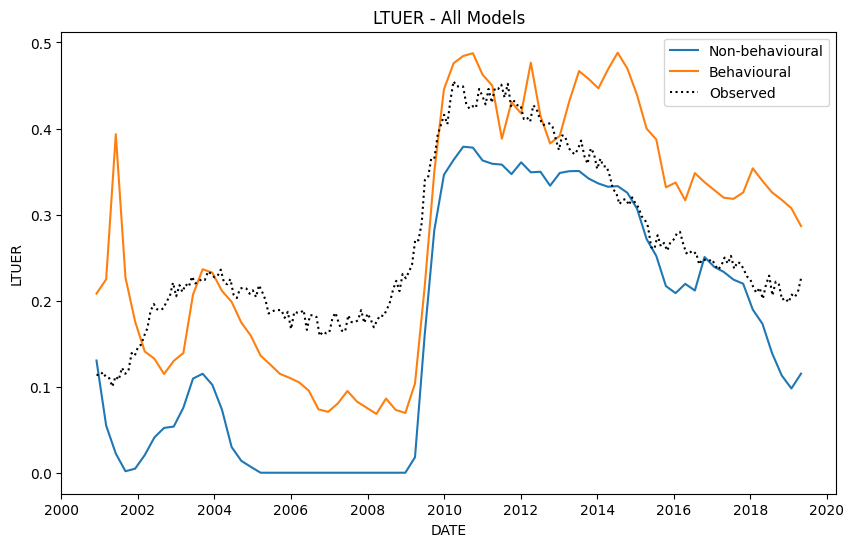

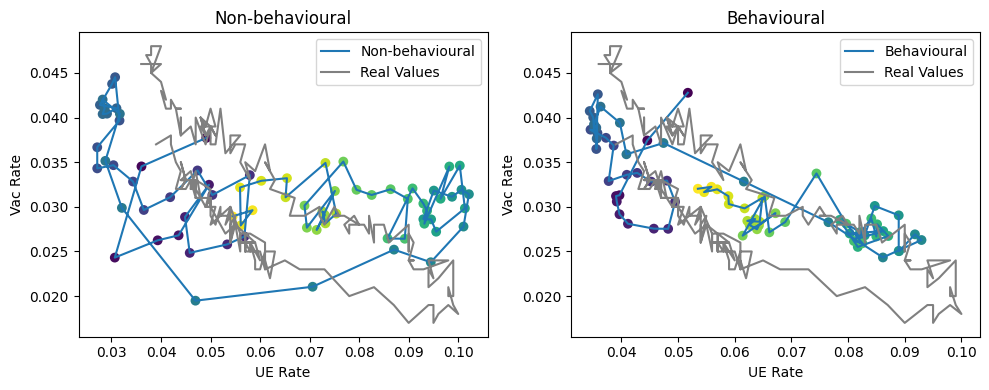

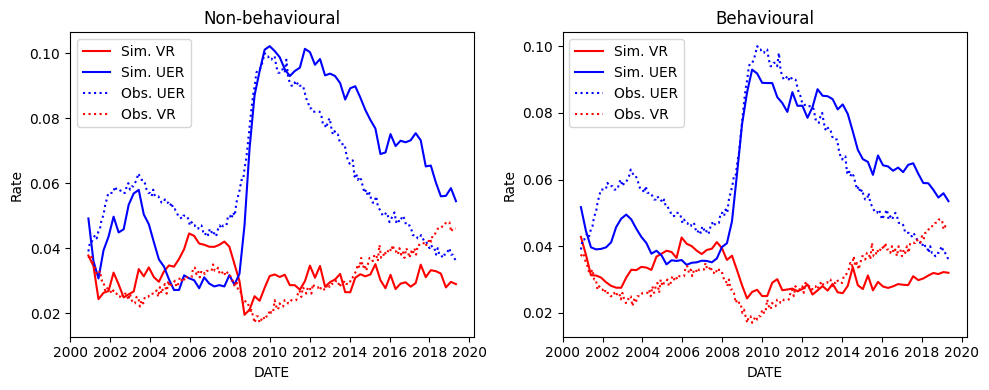

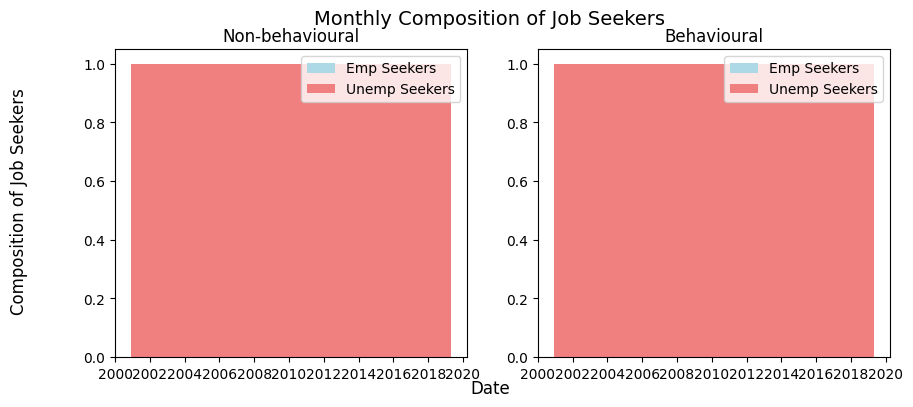

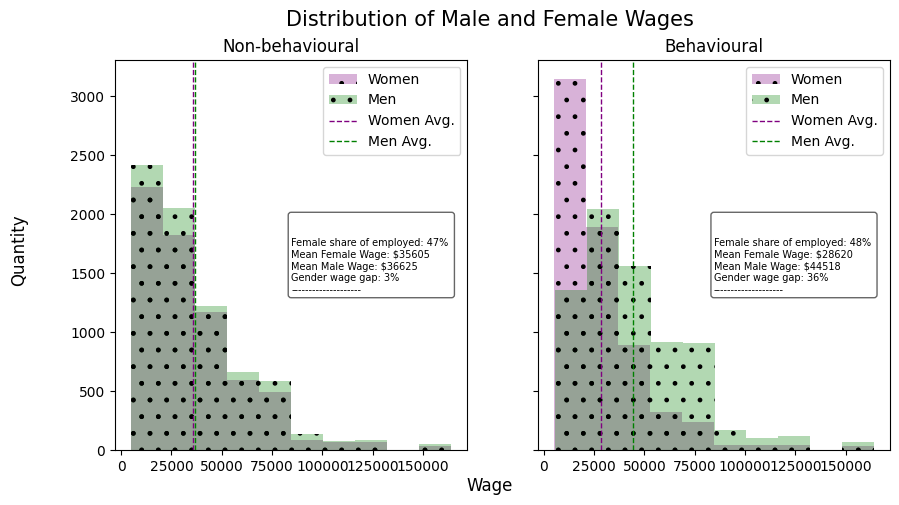

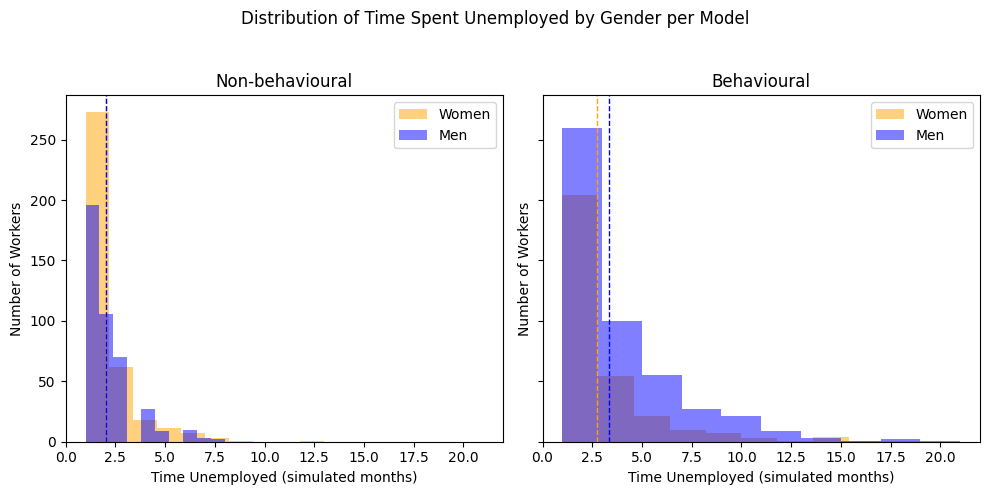

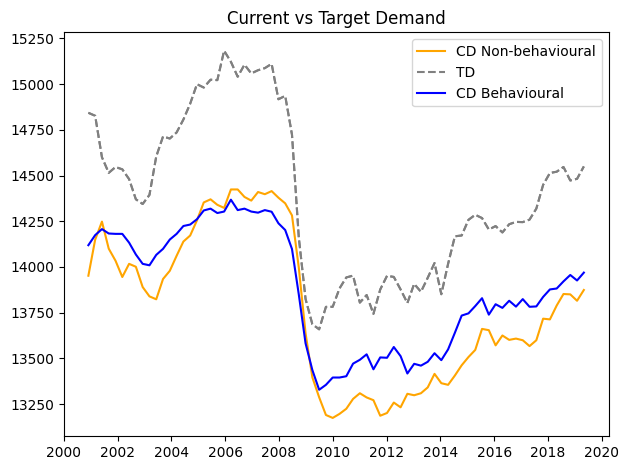

In [8]:
model_results = {
    "Non-behavioural": ue_vac_f,
    "Behavioural": ue_vac_t
}

net_results = {
    "Non-behavioural": sim_net_f,
    "Behavioural": sim_net_t
}

####################################################
############## CURRENT VS TARGET DEMAND ############
####################################################

plot_ltuer(model_results, observation)
plot_bev_curve(model_results, observation)
plot_uer_vac(model_results, observation, recessions)
plot_seeker_comp(model_results, share = True)
plot_gender_gaps(net_results)
plot_ltuer_dist(net_results, gender = True)
plot_cd_vs_td(model_results)

In [ ]:
table_list = []
res_dict = {}
net_dict = {}
folder_names = {
    "w.o OTJ": "dist_50_50",
    "w. OTJ": "otj_0_1",
    "w. OTJ & BK Filter": "otj_BK",
    "w. OTJ & Hamilton": "otj_hamilton"
    "w. OTJ & discouragement": "otj_discouragement"
}

for name, folder in folder_names.items():
    # Copy base parameters
    temp_params = deepcopy(params)

    # GDP data based on folder name
    if "BK" in folder:
        temp_params.update({'gdp_data': gdp_dat_bk, 'time_steps': len(gdp_dat_bk)})
    elif "hamilton" in folder:
        temp_params.update({'gdp_data': gdp_dat_hamilton, 'time_steps': len(gdp_dat_hamilton)})
    else:
        temp_params.update({'gdp_data': gdp_dat, 'time_steps': len(gdp_dat)})

    # OTJ flag
    temp_params.update({'otj': "otj" in folder})

    # Read parameters
    param_df = pd.read_csv(f'output_18_04/{folder}/calibrated_params_all.csv')
    param_df = param_df.sort_values(by='Timestamp', ascending=False)
    param_df = param_df.drop_duplicates(subset=['Parameter', 'Behav_Mode'], keep='first')

    # Dictionary to store results for both behavior modes
    behav_results = {}

    for beh in [False, True]:
        params_with_behav = deepcopy(temp_params)
        params_with_behav.update({'behav_spec': beh})

        # Pull params corresponding to the correct behavior mode
        behav_param_dict = param_df[param_df['Behav_Mode'] == beh].set_index('Parameter')['Value'].to_dict()
        params_with_behav.update(behav_param_dict)

        # Run model and save result
        run_result = run_single_local(**params_with_behav)
        behav_results[beh] = run_result[2]
        
        res_dict[f'{name}_{beh}'] = plot_records(run_result[0], calib_date[0], calib_date[1])
        net_dict[f'{name}_{beh}'] = run_result[1]

    # Append final entry to results list
    table_list.append({
        "name": name,
        True: behav_results[True],
        False: behav_results[False]
    })


False
False
True
True
False
False
True
True
False
False
True
True
False
False
True
True


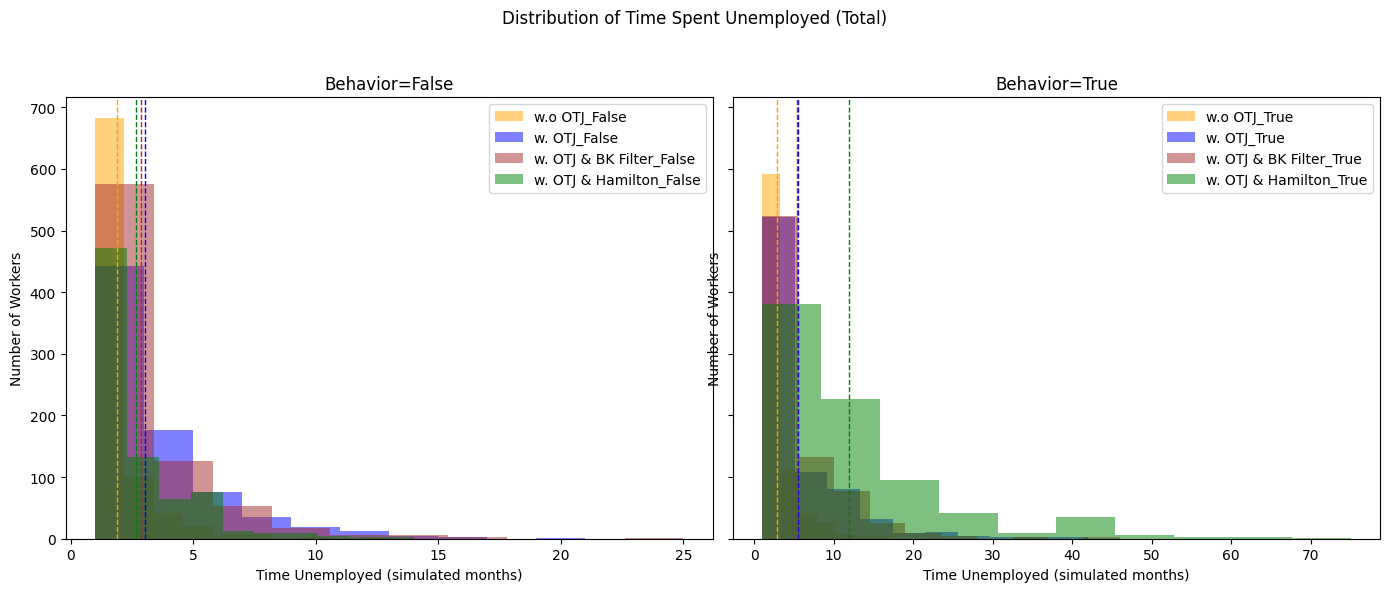

In [105]:

#plot_ltuer(res_dict,  observation, sep = True)
#plot_bev_curve(res_dict, observation, sep = True)
#plot_uer_vac(res_dict, observation, recessions, sep = True)
#plot_seeker_comp(res_dict, sep = True, share = True)
#plot_gender_gaps(net_dict, sep = True)
plot_ltuer_dist(net_dict, gender = False)
#plot_cd_vs_td(res_dict)

In [37]:
table = pd.DataFrame(table_list)

def harmonise_length(x, y):
    """
    GDP data used to calibrate has lower periodicity than the UER and VACRATE used for calibration. The following linearly interpolates the simulated output to match the frequency of the UER and Vacancy Rate data
    Harmonises the length of the time series to compare to each other. 
        
    Args:
        x (dict): Simulated data with keys "UER" and "VACRATE".
        y (dict): Real-world data with keys "UER" and "VACRATE".
    
    Returns:
        expanded_format: x expanded via linear interpolation - now of same length as y (observed time series of UER and vacancy rate)
    """
    expanded_format = pd.DataFrame({
        col: np.interp(
            np.linspace(0, len(x[col]) - 1, len(y[col])),
            np.linspace(0, len(x[col]) - 1, len(x[col])),
            x[col]
            )
            for col in x.keys()
            })
    return expanded_format

rows = []

for entry in table_list:
    model_name = entry["name"]
    for behavior in [True, False]:
        res = entry[behavior]
        x_ = harmonise_length(res, observation)
        uer_sse = np.sum((x_["UER"] - observation["UER"])**2) / np.var(observation["UER"])
        vacrate_sse = np.sum((x_["VACRATE"] - observation["VACRATE"])**2) / np.var(observation["VACRATE"])

        rows.append({
            "Model": model_name,
            "Behavior": behavior,
            "UER": uer_sse,
            "VACRATE": vacrate_sse,
            'Joint': uer_sse + vacrate_sse
        })

# Create DataFrame in tidy (long) format
df_long = pd.DataFrame(rows)
df_wide = df_long.pivot(index="Model", columns="Behavior")
df_wide.columns.names = ["Metric", "Behaviour"]  # label the column levels

df_sorted = df_wide.sort_values(by=df_wide.columns[-1])

df_sorted_table = pd.DataFrame(df_sorted)
df_sorted_table


Metric                     UER                 VACRATE              \
Behaviour                False       True        False       True    
Model                                                                
w. OTJ & BK Filter  125.399615  125.011597  205.333406  173.290846   
w. OTJ & Hamilton    49.489516  141.447816  214.984447  176.630665   
w. OTJ               93.416238   73.114118  225.082896  265.144275   
w.o OTJ             250.191727  108.719862  260.330753  271.008258   

Metric                   Joint              
Behaviour                False       True   
Model                                       
w. OTJ & BK Filter  330.733021  298.302443  
w. OTJ & Hamilton   264.473963  318.078480  
w. OTJ              318.499134  338.258393  
w.o OTJ             510.522480  379.728121